In [1]:
import os
import copy
import time

import torch
import torch.nn as nn
import torchvision

from torchvision import datasets, models
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchsummary import summary

from sklearn.metrics import classification_report, confusion_matrix

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
# Const variables

# Dataset root
DATASET_DIR_ROOT = "/kaggle/input/eye-diseases-classification/dataset"

# Number of epochs
n_epochs = 20

# Input images size
image_size = 256

# Number of batches
batch_size = 32

# Number of workers for dataloaders
num_workers = 4

In [3]:
import os

DATASET_DIR_ROOT = "/kaggle/input/eye-diseases-classification/dataset"

if os.path.exists(DATASET_DIR_ROOT):
    print("Dataset directory exists. Contents:")
    print(os.listdir(DATASET_DIR_ROOT))
else:
    print("Dataset directory not found. Check the path.")


Dataset directory exists. Contents:
['glaucoma', 'normal', 'diabetic_retinopathy', 'cataract']


In [4]:
import os

# Define the folder path
folder_path = "/kaggle/input/eye-diseases-classification/dataset/cataract"

# Get the list of image files
image_files = [file for file in os.listdir(folder_path) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Count the number of images
num_images = len(image_files)

print(f"Number of images in the 'cataract' folder: {num_images}")


Number of images in the 'cataract' folder: 1038


In [5]:
import os

# Define the folder path
folder_path = "/kaggle/input/eye-diseases-classification/dataset/diabetic_retinopathy"

# Get the list of image files
image_files = [file for file in os.listdir(folder_path) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Count the number of images
num_images = len(image_files)

print(f"Number of images in the 'diabetic_retinopathy' folder: {num_images}")


Number of images in the 'diabetic_retinopathy' folder: 1098


In [6]:
import os

# Define the folder path
folder_path = "/kaggle/input/eye-diseases-classification/dataset/glaucoma"

# Get the list of image files
image_files = [file for file in os.listdir(folder_path) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Count the number of images
num_images = len(image_files)

print(f"Number of images in the 'glaucoma' folder: {num_images}")


Number of images in the 'glaucoma' folder: 1007


In [7]:
import os

# Define the folder path
folder_path = "/kaggle/input/eye-diseases-classification/dataset/normal"

# Get the list of image files
image_files = [file for file in os.listdir(folder_path) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Count the number of images
num_images = len(image_files)

print(f"Number of images in the 'normal' folder: {num_images}")


Number of images in the 'normal' folder: 1074


In [8]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split

# Define paths
DATASET_DIR_ROOT = "/kaggle/input/eye-diseases-classification/dataset"
OUTPUT_DIR = "/kaggle/working/split_dataset"

# Split ratios
train_ratio = 0.7
val_ratio = 0.15  # 15% for validation
test_ratio = 0.15  # 15% for testing

# Create output directories
for split in ['train', 'validation', 'test']:
    split_path = os.path.join(OUTPUT_DIR, split)
    os.makedirs(split_path, exist_ok=True)

# Iterate over each class and split images
for class_name in os.listdir(DATASET_DIR_ROOT):
    class_path = os.path.join(DATASET_DIR_ROOT, class_name)
    
    if not os.path.isdir(class_path):  # Skip if it's not a folder
        continue

    images = os.listdir(class_path)
    random.shuffle(images)  # Shuffle images to avoid bias

    # Splitting dataset
    train_images, temp_images = train_test_split(images, test_size=(1 - train_ratio), random_state=42)
    val_images, test_images = train_test_split(temp_images, test_size=test_ratio / (test_ratio + val_ratio), random_state=42)

    # Function to move images
    def move_images(image_list, split):
        split_class_path = os.path.join(OUTPUT_DIR, split, class_name)
        os.makedirs(split_class_path, exist_ok=True)
        for img in image_list:
            shutil.copy(os.path.join(class_path, img), os.path.join(split_class_path, img))

    # Move images into respective folders
    move_images(train_images, 'train')
    move_images(val_images, 'validation')
    move_images(test_images, 'test')

print("Dataset successfully split into train, validation, and test sets!")


Dataset successfully split into train, validation, and test sets!


In [9]:
from torchvision import datasets, transforms

SPLIT_DATASET_DIR = "/kaggle/working/split_dataset"

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load datasets
train_set = datasets.ImageFolder(root=os.path.join(SPLIT_DATASET_DIR, "train"), transform=transform)
validation_set = datasets.ImageFolder(root=os.path.join(SPLIT_DATASET_DIR, "validation"), transform=transform)
test_set = datasets.ImageFolder(root=os.path.join(SPLIT_DATASET_DIR, "test"), transform=transform)

print(f"Train set: {len(train_set)} images")
print(f"Validation set: {len(validation_set)} images")
print(f"Test set: {len(test_set)} images")


Train set: 2949 images
Validation set: 633 images
Test set: 635 images


In [10]:
# Define transforms for each dataset separately

train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(1),
    transforms.RandomRotation(45),
    transforms.RandomAdjustSharpness(1.3, 1),
    transforms.ToTensor(),
    # transforms.Normalize(mean, std)
])

validation_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    # transforms.Normalize(mean, std)
])

test_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    # transforms.Normalize(mean, std)
])

In [11]:
# Load datasets

train_set = datasets.ImageFolder(
    root=os.path.join(DATASET_DIR_ROOT, "/kaggle/working/split_dataset/train"),
    transform=train_transforms
)

validation_set = datasets.ImageFolder(
    root=os.path.join(DATASET_DIR_ROOT, "/kaggle/working/split_dataset/validation"),
    transform=validation_transforms
)

test_set = datasets.ImageFolder(
    root=os.path.join(DATASET_DIR_ROOT, "/kaggle/working/split_dataset/test"),
    transform=test_transforms
)

In [12]:
# Instantiate DataLoaders

train_loader = DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)

validation_loader = DataLoader(
    dataset=validation_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers
)

test_loader = DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers
)

In [13]:
sns.set_style('darkgrid')

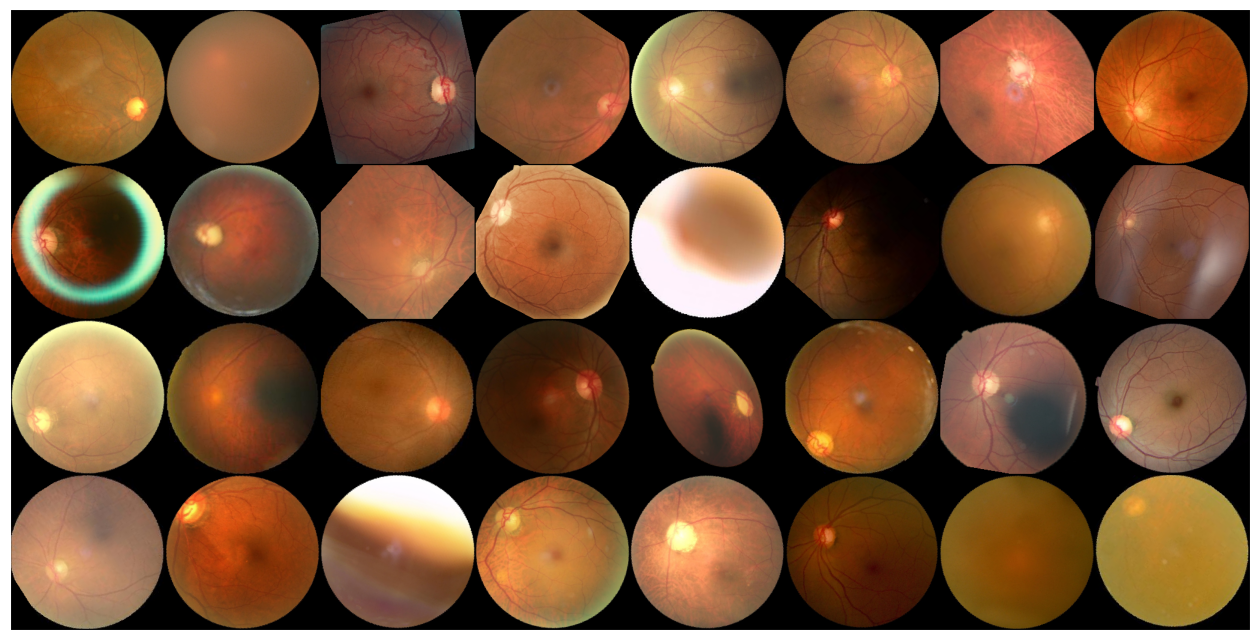

In [14]:
def grid_display(dataloader):
    
    for images, labels in dataloader:
        fig, ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1,2,0))
        break
        
grid_display(train_loader)

In [15]:
def label_distribution(dataset):
    
    encoded_labels = {v:k for k, v in dataset.class_to_idx.items()} # {0: 'cataract', 1: 'diabetic_retinopathy', 2: 'glaucoma', 3: 'normal'}
    labels_count = {k:0 for k in dataset.class_to_idx} # {'cataract': 0, 'diabetic_retinopathy': 0, 'glaucoma': 0, 'normal': 0}

    for label_code in encoded_labels:
        labels_count[encoded_labels[label_code]] = dataset.targets.count(label_code)
    return labels_count

In [16]:
def plot_from_dict(dict_obj: dict, plot_title: str, **kwargs):
    
    df = pd.DataFrame.from_dict([dict_obj]).melt()
    df.rename(columns={'variable': 'Dataset Labels', 'value': 'Number of samples'}, inplace=True)
    return sns.barplot(
        data=df,
        x="Dataset Labels",
        y="Number of samples",
        hue="Dataset Labels",
        **kwargs
    ).set_title(label=plot_title)

Text(0.5, 1.0, 'Test Set')

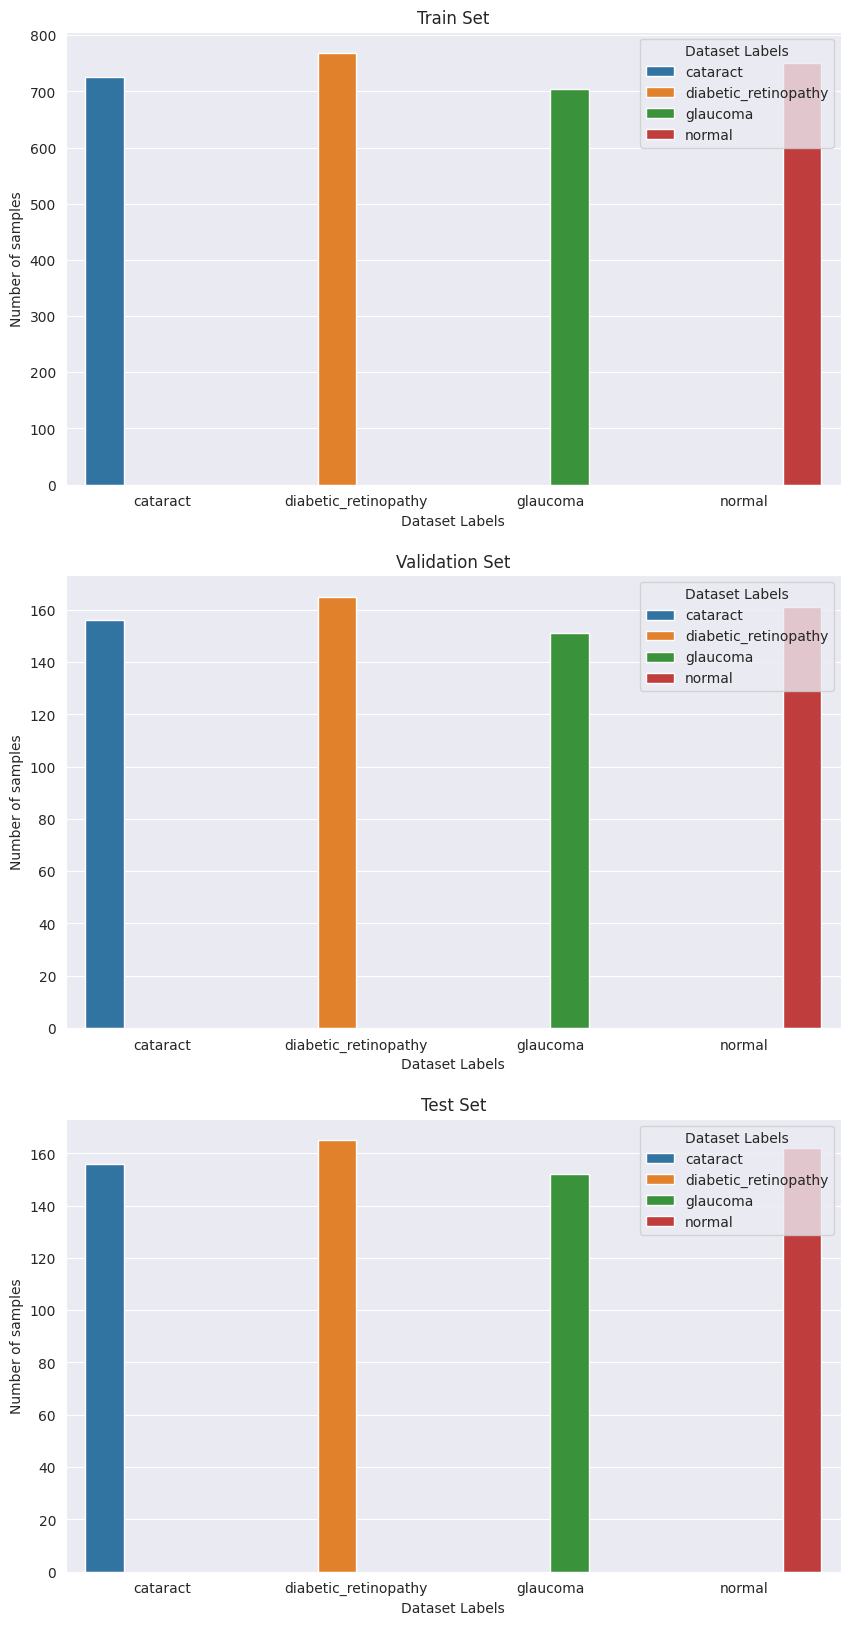

In [17]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 20))
plot_from_dict(label_distribution(train_set), plot_title="Train Set", ax=axes[0])
plot_from_dict(label_distribution(validation_set), plot_title="Validation Set", ax=axes[1])
plot_from_dict(label_distribution(test_set), plot_title="Test Set", ax=axes[2])

In [18]:
class EyeSeeNet(nn.Module):
    def __init__(self, num_class):
        super(EyeSeeNet, self).__init__()
        self.num_class = num_class
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Sequential(
            nn.Linear(128*14*14, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, self.num_class)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 128*14*14)
        x = self.fc(x)
        return x

In [19]:
from torchsummary import summary


In [20]:
# Summary of the architecture of RetinalEnsemble

summary(EyeSeeNet(4), (3, image_size, image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 254, 254]             448
       BatchNorm2d-2         [-1, 16, 254, 254]              32
              ReLU-3         [-1, 16, 254, 254]               0
         MaxPool2d-4         [-1, 16, 127, 127]               0
            Conv2d-5         [-1, 32, 125, 125]           4,640
       BatchNorm2d-6         [-1, 32, 125, 125]              64
              ReLU-7         [-1, 32, 125, 125]               0
         MaxPool2d-8           [-1, 32, 62, 62]               0
            Conv2d-9           [-1, 64, 60, 60]          18,496
      BatchNorm2d-10           [-1, 64, 60, 60]             128
             ReLU-11           [-1, 64, 60, 60]               0
        MaxPool2d-12           [-1, 64, 30, 30]               0
           Conv2d-13          [-1, 128, 28, 28]          73,856
      BatchNorm2d-14          [-1, 128,

In [21]:
# Define device : GPU, MPS, or CPU

device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
elif torch.backends.mps.is_available():
    device = "mps"
    
print(device)

cpu


In [22]:
# Instanciate and Transfer model on the device

model = EyeSeeNet(4).to(device)

In [23]:
# Loss & Optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [24]:
# Train model

train_losses = np.zeros(n_epochs)
val_losses = np.zeros(n_epochs)
best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())
since = time.time()

for epoch in range(n_epochs):
    train_corrects = 0
    train_loss = 0.0

    model.train()
    for inputs, targets in tqdm(train_loader, desc=f'Training... Epoch: {epoch + 1}/{n_epochs}'):

        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        _, preds = torch.max(outputs, 1)
        train_corrects += torch.sum(preds == targets.data)
        train_loss += loss.item() * inputs.size(0)

        loss.backward()
        optimizer.step()
            
    train_loss = train_loss / len(train_loader.dataset)
    train_acc = train_corrects / len(train_loader.dataset)
    
    with torch.no_grad():
        val_corrects = 0
        val_loss = 0.0
        model.eval()

        for inputs, targets in tqdm(validation_loader, desc=f'Validating... Epoch: {epoch + 1}/{n_epochs}'):
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == targets.data)
            val_loss += loss.item() * inputs.size(0)
        
        val_loss = val_loss / len(validation_loader.dataset)
        val_acc = val_corrects / len(validation_loader.dataset)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
    
    # save epoch losses
    train_losses[epoch] = train_loss
    val_losses[epoch] = val_loss
    
    print(f"Epoch {epoch+1}/{n_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
    print('-'*30)

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
model.load_state_dict(best_model_wts)

Validating... Epoch: 1/20: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Epoch 1/20:
Train Loss: 1.0813, Train Accuracy: 0.5293
Validation Loss: 0.9383, Validation Accuracy: 0.6414
------------------------------


Validating... Epoch: 2/20: 100%|██████████| 20/20 [00:13<00:00,  1.52it/s]


Epoch 2/20:
Train Loss: 0.7811, Train Accuracy: 0.6755
Validation Loss: 0.8134, Validation Accuracy: 0.6367
------------------------------


Validating... Epoch: 3/20: 100%|██████████| 20/20 [00:14<00:00,  1.39it/s]


Epoch 3/20:
Train Loss: 0.6617, Train Accuracy: 0.7270
Validation Loss: 0.6571, Validation Accuracy: 0.7441
------------------------------


Validating... Epoch: 4/20: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Epoch 4/20:
Train Loss: 0.6255, Train Accuracy: 0.7403
Validation Loss: 0.6696, Validation Accuracy: 0.7251
------------------------------


Validating... Epoch: 5/20: 100%|██████████| 20/20 [00:13<00:00,  1.46it/s]


Epoch 5/20:
Train Loss: 0.5548, Train Accuracy: 0.7782
Validation Loss: 0.5905, Validation Accuracy: 0.7709
------------------------------


Validating... Epoch: 6/20: 100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


Epoch 6/20:
Train Loss: 0.5116, Train Accuracy: 0.7938
Validation Loss: 0.6895, Validation Accuracy: 0.7314
------------------------------


Validating... Epoch: 7/20: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch 7/20:
Train Loss: 0.4994, Train Accuracy: 0.7921
Validation Loss: 0.5089, Validation Accuracy: 0.7773
------------------------------


Validating... Epoch: 8/20: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Epoch 8/20:
Train Loss: 0.4737, Train Accuracy: 0.8135
Validation Loss: 0.5252, Validation Accuracy: 0.7930
------------------------------


Validating... Epoch: 9/20: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


Epoch 9/20:
Train Loss: 0.4293, Train Accuracy: 0.8237
Validation Loss: 0.5378, Validation Accuracy: 0.8009
------------------------------


Validating... Epoch: 10/20: 100%|██████████| 20/20 [00:13<00:00,  1.45it/s]


Epoch 10/20:
Train Loss: 0.4334, Train Accuracy: 0.8240
Validation Loss: 0.4549, Validation Accuracy: 0.8136
------------------------------


Validating... Epoch: 11/20: 100%|██████████| 20/20 [00:14<00:00,  1.38it/s]


Epoch 11/20:
Train Loss: 0.4099, Train Accuracy: 0.8362
Validation Loss: 0.6811, Validation Accuracy: 0.6888
------------------------------


Validating... Epoch: 12/20: 100%|██████████| 20/20 [00:13<00:00,  1.46it/s]


Epoch 12/20:
Train Loss: 0.4134, Train Accuracy: 0.8301
Validation Loss: 0.5022, Validation Accuracy: 0.7820
------------------------------


Validating... Epoch: 13/20: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


Epoch 13/20:
Train Loss: 0.4282, Train Accuracy: 0.8206
Validation Loss: 0.4857, Validation Accuracy: 0.8041
------------------------------


Validating... Epoch: 14/20: 100%|██████████| 20/20 [00:13<00:00,  1.45it/s]


Epoch 14/20:
Train Loss: 0.3743, Train Accuracy: 0.8464
Validation Loss: 0.4588, Validation Accuracy: 0.8310
------------------------------


Validating... Epoch: 15/20: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


Epoch 15/20:
Train Loss: 0.3604, Train Accuracy: 0.8532
Validation Loss: 0.4706, Validation Accuracy: 0.8310
------------------------------


Validating... Epoch: 16/20: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Epoch 16/20:
Train Loss: 0.3629, Train Accuracy: 0.8498
Validation Loss: 0.4495, Validation Accuracy: 0.8104
------------------------------


Validating... Epoch: 17/20: 100%|██████████| 20/20 [00:14<00:00,  1.39it/s]


Epoch 17/20:
Train Loss: 0.3669, Train Accuracy: 0.8467
Validation Loss: 0.4521, Validation Accuracy: 0.8483
------------------------------


Validating... Epoch: 18/20: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Epoch 18/20:
Train Loss: 0.3543, Train Accuracy: 0.8559
Validation Loss: 0.7435, Validation Accuracy: 0.6904
------------------------------


Validating... Epoch: 19/20: 100%|██████████| 20/20 [00:14<00:00,  1.40it/s]


Epoch 19/20:
Train Loss: 0.3478, Train Accuracy: 0.8583
Validation Loss: 0.4337, Validation Accuracy: 0.8231
------------------------------


Validating... Epoch: 20/20: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]

Epoch 20/20:
Train Loss: 0.3325, Train Accuracy: 0.8633
Validation Loss: 0.4253, Validation Accuracy: 0.8262
------------------------------
Training complete in 62m 20s


<All keys matched successfully>

In [27]:
import os
import torch

save_dir = "path_to_save_model"
os.makedirs(save_dir, exist_ok=True)  # Create directory if it doesn't exist

# Save the model
torch.save(model.state_dict(), os.path.join(save_dir, "fmodel.pth"))


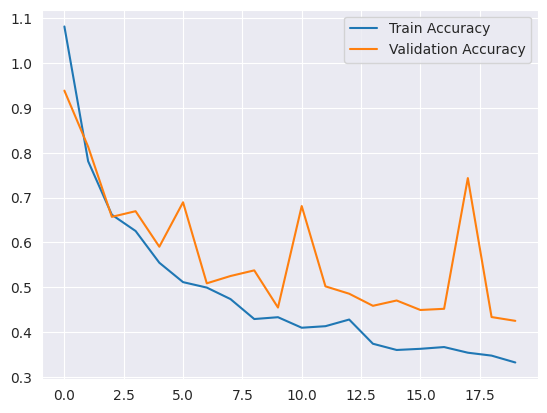

In [28]:
plt.plot(train_losses, label="Train Accuracy")
plt.plot(val_losses, label="Validation Accuracy")
plt.legend()
plt.show()

In [29]:
# Calculate Train and Validation Accuracy

def cal_accuracy(data_loader):
    n_correct = 0
    n_total = 0
    
    for inputs, targets in data_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)

        n_correct += (predictions == targets).sum().item()
        n_total += targets.shape[0]

    accuracy = n_correct / n_total

    return accuracy


print(f"Train Accuracy: {cal_accuracy(train_loader):.4f}, Validation Accuracy: {cal_accuracy(validation_loader):.4f}, Test Accuracy: {cal_accuracy(test_loader):.4f}")

Train Accuracy: 0.8688, Validation Accuracy: 0.8483, Test Accuracy: 0.8268


In [30]:
y_true_list = []
y_pred_list = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)

        y_true_list.append(targets.cpu().numpy())
        y_pred_list.append(predictions.cpu().numpy())

# flatten data of batches into a 1-d list
y_true_list = list(np.concatenate(y_true_list).flat)
y_pred_list = list(np.concatenate(y_pred_list).flat)

In [31]:
# Classification Report

print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.79      0.92      0.85       156
           1       0.94      0.99      0.96       165
           2       0.82      0.56      0.66       152
           3       0.75      0.83      0.79       162

    accuracy                           0.83       635
   macro avg       0.83      0.82      0.82       635
weighted avg       0.83      0.83      0.82       635



In [32]:
# Confusion Matrix

print(confusion_matrix(y_true_list, y_pred_list))

[[143   2   6   5]
 [  1 163   1   0]
 [ 27   1  85  39]
 [  9   7  12 134]]


<Axes: >

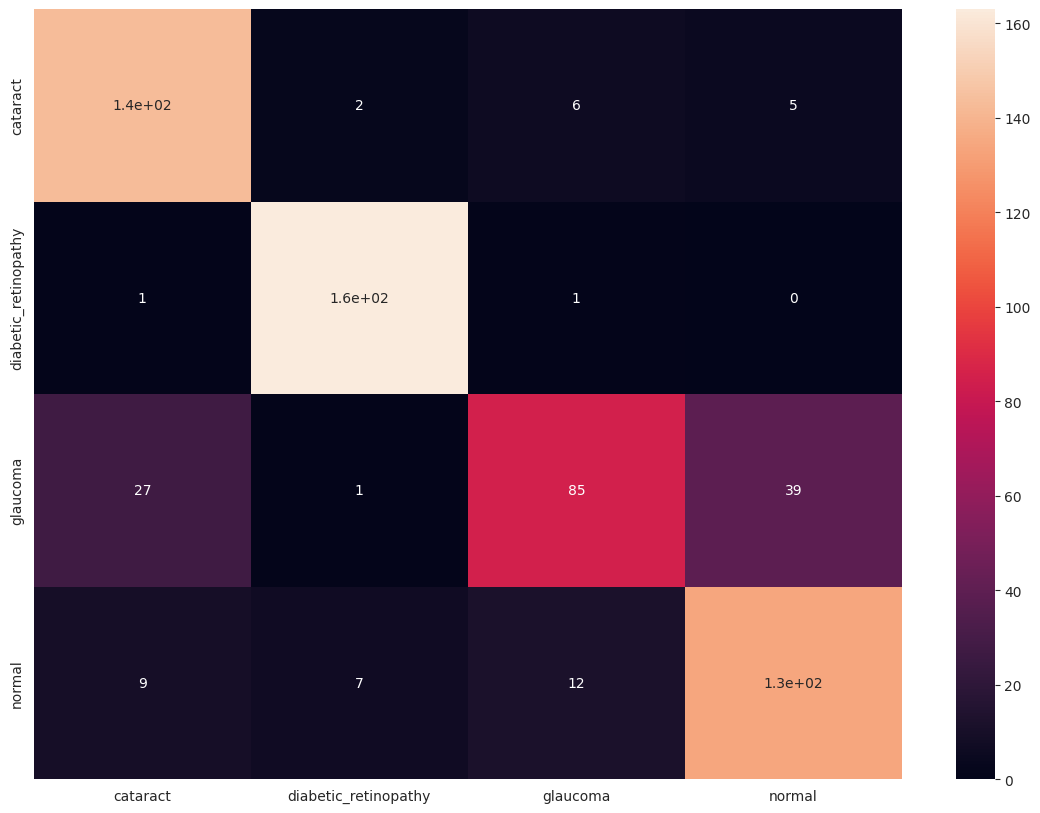

In [33]:
# Plot the Confusion Matrix

def plot_confusion_matrix(dataset, y_true_list, y_pred_list):
    index_to_label = {v:k for k, v in dataset.class_to_idx.items()}
    confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list, y_pred_list)).rename(columns=index_to_label, index=index_to_label)
    fig, ax = plt.subplots(figsize=(14,10))         
    return sns.heatmap(confusion_matrix_df, annot=True, ax=ax)


plot_confusion_matrix(test_set, y_true_list, y_pred_list)

25 of Misclassified Images:


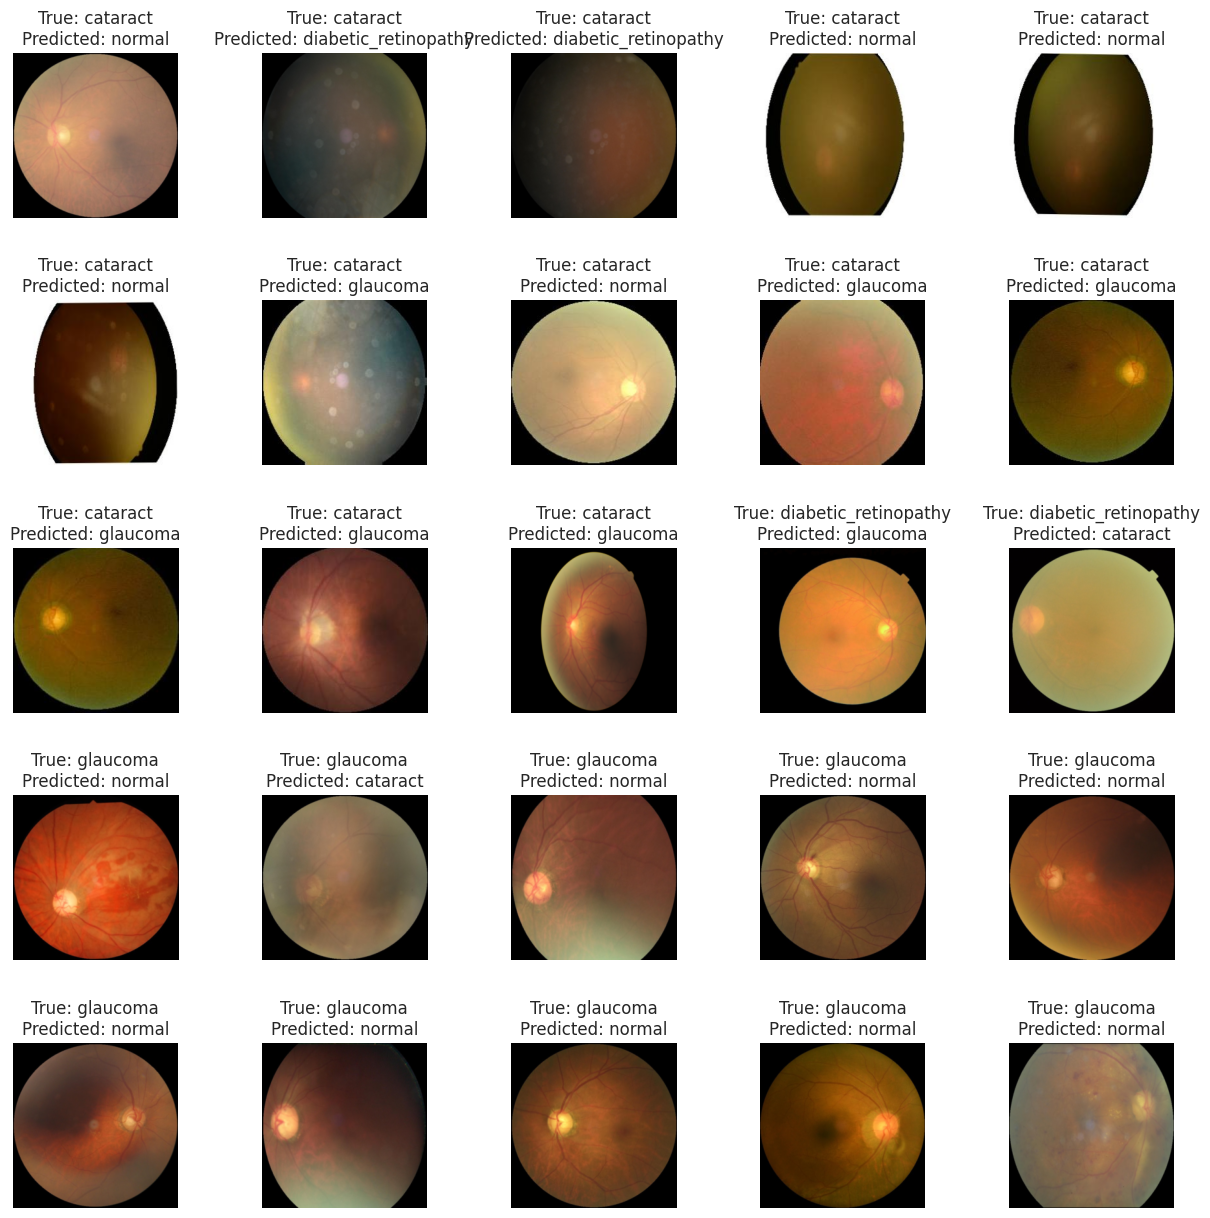

In [34]:
# Plot some of misclassified instances

n_missclassified = 25

encoded_labels = {v:k for k, v in train_set.class_to_idx.items()}
misclassified_idx = np.where(np.array(y_true_list) != np.array(y_pred_list))[0]

print(f"{n_missclassified} of Misclassified Images:")
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
for i, mis_index in enumerate(misclassified_idx[:n_missclassified]):
    ax = axes.ravel()[i]
    ax.imshow(test_set[mis_index][0].permute(1, 2, 0))
    ax.set_title(f"True: {encoded_labels[y_true_list[mis_index]]}\nPredicted: {encoded_labels[y_pred_list[mis_index]]}")
    ax.axis('off')
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()